In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from PIL import Image
import cv2
import os
import numpy as np
from tqdm import tqdm
from models import AttU_Net
device = "cuda" if torch.cuda.is_available() else "cpu"

## Generate prediction from test_images file

In [2]:
DATA_PATH_IMG = "./data/test_images/"
DATA_PATH_MSK = "./data/test_masks/"
MODEL_PATH = "./models/best_model_iou_epoch_81.pth"

model = AttU_Net(3,1)
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def predict_on_test_set(model, dossier_test, transformations, seuil=0.5, dossier_resultats="resultats"):
    model.eval()
    
    if not os.path.exists(dossier_resultats):
        os.makedirs(dossier_resultats)

    files = [f for f in os.listdir(dossier_test) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for fichier in tqdm(files, desc="Processing", unit="image"):
        chemin_fichier = os.path.join(dossier_test, fichier)

        image = Image.open(chemin_fichier).convert("RGB")
        image = transformations(image)
        image = image.unsqueeze(0)

        with torch.no_grad():
            prediction = torch.sigmoid(model(image)).squeeze(0)

        prediction_binarisee = (prediction.squeeze().cpu().numpy() > seuil).astype(np.uint8) * 255

        chemin_resultat = os.path.join(dossier_resultats, f"prediction_{fichier}")
        cv2.imwrite(chemin_resultat, prediction_binarisee)


dossier_test = DATA_PATH_IMG
resultats = predict_on_test_set(model, dossier_test, transformations)


Processing: 100%|██████████| 552/552 [04:16<00:00,  2.16image/s]


## Compute IoU for each prediction previously generated

In [3]:
def resize_image_opencv(image_path, target_size):
    image = cv2.imread(image_path)
    # Convertir de BGR (OpenCV) à RGB
    resized_image = cv2.cvtColor(cv2.resize(image, (target_size, target_size)), cv2.COLOR_BGR2RGB)
    return resized_image

def calculate_iou(gt_folder, pred_folder, target_size=256):
    iou_values = {}

    for gt_image_name in os.listdir(gt_folder):
        if gt_image_name.endswith('.png'):
            gt_image_path = os.path.join(gt_folder, gt_image_name)

            pred_image_name = f"prediction_{gt_image_name}"
            pred_image_path = os.path.join(pred_folder, pred_image_name)

            if os.path.exists(pred_image_path):
                resized_gt_array = resize_image_opencv(gt_image_path, target_size)
                resized_pred_array = resize_image_opencv(pred_image_path, target_size)

                intersection = np.logical_and(resized_gt_array, resized_pred_array).sum()
                union = np.logical_or(resized_gt_array, resized_pred_array).sum()

                iou = intersection / union if union != 0 else 0.0
                iou_values[gt_image_name] = iou
            else:
                print(f"Missing prediction image: {gt_image_name}")

    return iou_values

gt_folder = DATA_PATH_MSK
pred_folder = "./resultats/"

iou_values = calculate_iou(gt_folder, pred_folder)
for image_name, iou in iou_values.items():
    print(f"IoU {image_name}: {iou}")


IoU fusc_0001.png: 0.6266094420600858
IoU fusc_0004.png: 0.41798941798941797
IoU fusc_0005.png: 0.6869747899159664
IoU fusc_0007.png: 0.39831981460023175
IoU fusc_0009.png: 0.8769180541952334
IoU fusc_0012.png: 0.7353535353535353
IoU fusc_0013.png: 0.9279128248113998
IoU fusc_0014.png: 0.8390151515151515
IoU fusc_0015.png: 0.6408839779005525
IoU fusc_0021.png: 0.8327444051825678
IoU fusc_0022.png: 0.8933333333333333
IoU fusc_0023.png: 0.8567662565905096
IoU fusc_0024.png: 0.8495145631067961
IoU fusc_0025.png: 0.8993506493506493
IoU fusc_0026.png: 0.7660148347943359
IoU fusc_0027.png: 0.8376068376068376
IoU fusc_0028.png: 0.5892857142857143
IoU fusc_0030.png: 0.9646586345381526
IoU fusc_0035.png: 0.7599575146043548
IoU fusc_0037.png: 0.677734375
IoU fusc_0038.png: 0.7620967741935484
IoU fusc_0040.png: 0.9474114441416893
IoU fusc_0046.png: 0.7265957446808511
IoU fusc_0047.png: 0.7470817120622568
IoU fusc_0049.png: 0.7830264211369096
IoU fusc_0050.png: 0.615
IoU fusc_0052.png: 0.719047619

## Visualize IoU distribution of predictions

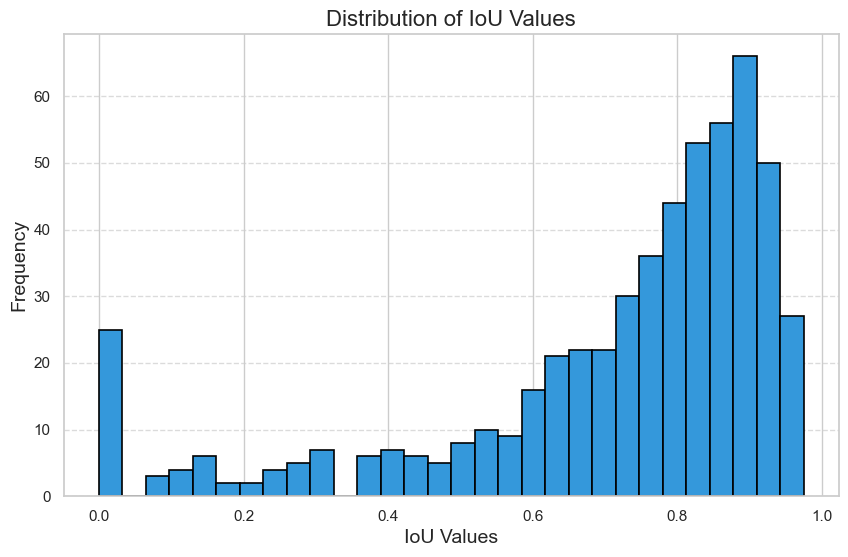

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_iou_distribution(iou_values):
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    plt.hist(list(iou_values.values()), bins=30, color='#3498db', edgecolor='black', linewidth=1.2)
    
    plt.title('Distribution of IoU Values', fontsize=16)
    plt.xlabel('IoU Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

visualize_iou_distribution(iou_values)


## Compute mean IoU

In [5]:
def calculate_mean_iou(iou_values):
    total_iou = 0.0
    num_images = len(iou_values)

    for iou in iou_values.values():
        total_iou += iou

    mean_iou = total_iou / num_images if num_images != 0 else 0.0
    return mean_iou

mean_iou = calculate_mean_iou(iou_values)

print(f"Mean IoU : {mean_iou}")

Mean IoU : 0.7093865198932784
